In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt

The ridge regression problem is formulated as,
$$\min_{x \in \mathbb{R}^{n}}f_{\lambda}(x) \qquad \text{where} \qquad f_{\lambda}(x) \doteq \frac{1}{2}\left\{\frac{1}{m}\|Ax - y\|_{2}^{2} + \lambda \|x\|_{2}^{2}\right\}$$
via gradient descent with step size $\eta > 0$.

### Fit Ridge regression for $n=1$ dimensions

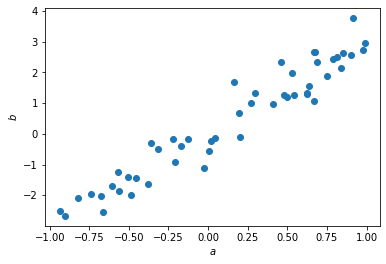

In [2]:
m = 50
n = 1
noise_std = 0.5

x_star = np.array([3]).reshape(1,)
A_1 = np.random.uniform(low=-1, high=1, size=(m, 1))
y_1 = A_1 @ x_star + noise_std * np.random.standard_normal((m,))

def plot_data_1d(A, y):
    plt.xlabel("$a$")
    plt.ylabel("$b$")
    plt.plot(A[:, 0], y, marker="o", linestyle="none")

plot_data_1d(A_1, y_1)

In [6]:
# TODO: Add picking of lambda based on conditioning number
lmbda_1 = 0.01

In [8]:
def sigma_max(A):
    S = np.linalg.svd(A, full_matrices=True, compute_uv=False)
    return S[0]

def sigma_min(A):
    S = np.linalg.svd(A, full_matrices=True, compute_uv=False)
    if S.shape[0] < A.shape[1]:
        return np.float64(0.0)
    else:
        return S[-1]

def eta_opt(A, lmbda):
    m, n = A.shape
    return 2 * m / (sigma_max(A) ** 2 + sigma_min(A) ** 2 + 2 * lmbda * m)

# Learning rate and regularization lambda
eta_1 = 0.001 * eta_opt(A_1, lmbda_1)

In [10]:
def make_f(A, y, lmbda):
    m, n = A.shape
    return lambda x: 0.5 * ((np.linalg.norm(A @ x - y) ** 2) / m + lmbda * np.linalg.norm(x) ** 2)

def gd(x0, grad_fn, eta, T):
    x_history = []
    x = x0
    for t in range(T):
        x = x - eta * grad_fn(x)  # Update rule of GD
        x_history.append(copy.deepcopy(x))

    return np.array(x_history)

def ridge_regression_gd(A, y, lmbda, eta, T):
    m, n = A.shape
    def grad_fn(x):
        A_tA = A.T @ A
        ridge = ((A_tA) + (lmbda * m * np.eye(n))).squeeze(-1)    
        return 2*(ridge @ x) - 2*(A.T @ y) 
    
    x0 = np.random.standard_normal((n,))
    return gd(x0, grad_fn, eta, T)

def ridge_regression_sol(A, y, lmbda):
    m, n = A.shape
    # Closed-form ridge regression solution to compare to
    return np.linalg.inv(A.T @ A + lmbda * m * np.eye(A.shape[1])) @ A.T @ y

T = 200
f_1 = make_f(A_1, y_1, lmbda_1)
x_history_1 = ridge_regression_gd(A_1, y_1, lmbda_1, eta_1, T)
x_rr_1 = ridge_regression_sol(A_1, y_1, lmbda_1)

x_rr_1, x_history_1[-1]

(array([2.87933401]), array([2.87933401]))

### Visualize the gradient descent fit
We visualize the regression lines obtained from our gradient descent iterates compared to the regression line obtained from the closed-form solution.

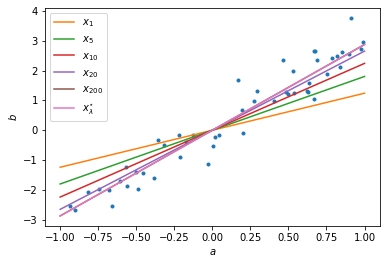

In [11]:
def plot_history_lines_1d(A, y, x_history, x_star, ts, time_avg=False):
    plt.xlabel("$a$")
    plt.ylabel("$b$")
    plt.plot(A[:, 0], y, ".")
    
    if time_avg:
        x_history = time_average(x_history)

    for t in ts:
        x_t = x_history[t-1][0]
        plt.plot([-1, 1], [-x_t, x_t], label="$x_{%s}$"%t)
    plt.plot([-1, 1], [-x_star, x_star], label="$x_{\lambda}^{\star}$")
    plt.legend()

plot_history_lines_1d(A_1, y_1, x_history_1, x_rr_1, [1, 5, 10, 20, 200])

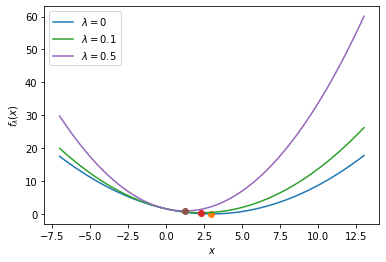

In [13]:
def plot_loss_curves_1d(A, y, lmbdas, x_star):
    m, n = A.shape
    assert n == 1
    for lmbda in lmbdas:
        f = make_f(A, y, lmbda)
        x_range = np.linspace(start=x_star - 10, stop=x_star + 10, num=1000).reshape(-1, 1)
        fx_range = np.array([f(x) for x in x_range])

        x_RR = ridge_regression_sol(A, y, lmbda)
        fx_RR = f(x_RR)

        plt.xlabel("$x$")
        plt.ylabel("$f_{\lambda}(x)$")
        plt.plot(x_range, fx_range, label = "$\lambda = %s$"%lmbda)

        plt.plot(x_RR, fx_RR, 'o')
    plt.legend()
    
plot_loss_curves_1d(A_1, y_1, [0, 0.1, 0.5], x_star)

We visualize the convergence of $x_{t}$ within the standard basis.

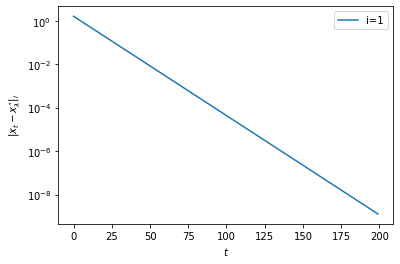

In [14]:
def plot_convergence_x(A, x_history, x_star, time_avg=False):
    if time_avg:
        x_history = time_average(x_history)
        
    x_history = x_history.T  # now it's a (N x T) matrix where each column is an x_t
    
    plt.xlabel("$t$")
    plt.ylabel("$|x_{t} - x_{\lambda}^{\star}|_{i}$")
    plt.yscale("log")
    for i in range(A.shape[1]):
        dist_xi = np.abs(x_history[i] - x_star[i])
        plt.plot(dist_xi, label="i=%s" % (i + 1))
    plt.legend()
    
plot_convergence_x(A_1, x_history_1, x_rr_1)

We visualize the convergence of $x_{t}$ within the $V$ basis. Since we are in 1D, the two plots look the same. But they will soon diverge as we move to higher dimensions.

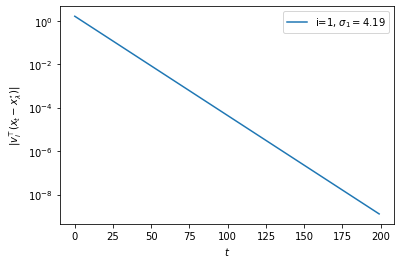

In [15]:
def plot_convergence_z(A, x_history, x_star, time_avg=False):
    if time_avg:
        x_history = time_average(x_history)
        
    U, S, Vt = np.linalg.svd(A)
    x_history = x_history.T  # now it's a (N x T) matrix where each column is an x_t
    z_history = Vt @ x_history  # project each x_t onto the V basis
    z_star = Vt @ x_star
    
    plt.xlabel("$t$")
    plt.ylabel("$|v_{i}^{\\top}(x_{t} - x_{\lambda}^{\star})|$")
    plt.yscale("log")
    for i in range(A.shape[1]):
        dist_zi = np.abs(z_history[i] - z_star[i])
        plt.plot(dist_zi, label="i=%s, $\sigma_{%s} = %s$" % (i + 1, i + 1, round(S[i], 2)))
    plt.legend()
    
plot_convergence_z(A_1, x_history_1, x_rr_1)

We visualize the convergence of $f_{\lambda}(x_{t})$.

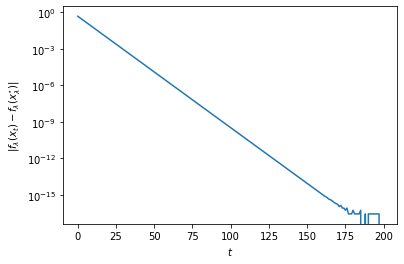

In [16]:
def plot_convergence_f(f, x_history, x_star, time_avg=False):
    if time_avg:
        x_history = time_average(x_history)
    
    f_history = np.array([f(x_history[i]) for i in range(len(x_history))])
    f_star = f(x_star)
    
    plt.xlabel("$t$")
    plt.ylabel("$|f_{\lambda}(x_{t}) - f_{\lambda}(x_{\lambda}^{\star})|$")
    dist_f = np.abs(f_history - f_star)
    plt.yscale("log")
    plt.plot(dist_f)
    
plot_convergence_f(f_1, x_history_1, x_rr_1)

The next plot shows how $x_{t}$ bounces around the loss landscape, more precisely plotting $(x_{t}, f_{\lambda}(x_{t}))$. Arrows point from $(x_{t}, f_{\lambda}(x_{t}))$ to $(x_{t + 1}, f_{\lambda}(x_{t + 1}))$ for all $t$. The optimal point $(x_{\lambda}^{\star}, f_{\lambda}(x_{\lambda}^{\star})$ is highlighted.

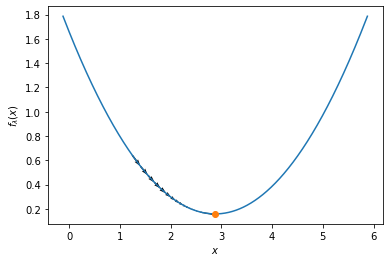

In [17]:
def plot_x_trajectory_1d(f, x_history, x_star, time_avg=False):
    if time_avg:
        x_history = time_average(x_history)
        
    x_range = np.linspace(start=x_star - 3, stop=x_star + 3, num=1000).reshape(-1, 1)
    fx_range = np.array([f(x) for x in x_range])

    plt.xlabel("$x$")
    plt.ylabel("$f_{\lambda}(x)$")
    plt.plot(x_range, fx_range)
    
    plt.plot(x_star, f(x_star), 'o')

    f_history = np.array([f(x) for x in x_history]).reshape(-1, 1)

    plt.quiver(x_history[:-1], f_history[:-1],\
           x_history[1:]-x_history[:-1], f_history[1:]-f_history[:-1],\
           scale_units='xy', angles='xy', scale=1)

plot_x_trajectory_1d(f_1, x_history_1, x_rr_1)

### Fit Ridge regression for $n=2$ dimensions

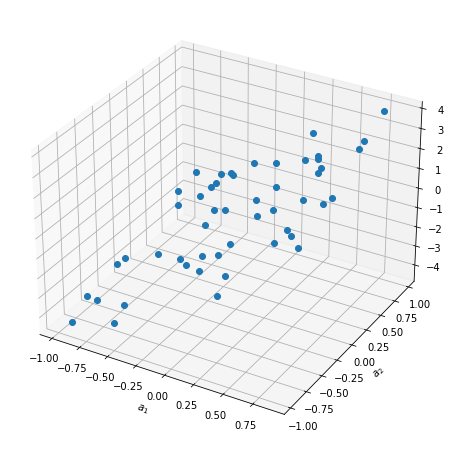

In [18]:
m_2 = 50
n_2 = 2
noise_std_2 = 0.5
x_star_2 = np.array([3, 1]).reshape(n_2,)  # (n,)
A_2 = np.random.uniform(low=-1, high=1, size=(m_2, n_2))  # (m, n)
y_2 = A_2 @ x_star_2 + noise_std_2 * np.random.standard_normal((m_2, ))  # (m,)

def plot_data_2d(A, y):
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    ax.set_xlabel("$a_{1}$")
    ax.set_ylabel("$a_{2}$")
    ax.plot(A[:, 0], A[:, 1], zs=y, marker="o", linestyle="none")
    
plot_data_2d(A_2, y_2)

In [19]:
sigma_max(A_1) / sigma_min(A_1)

1.0

In [31]:
lmbda_2 = 0.01  # TODO: Change this and write your thoughts in the answer PDF
eta_2 = 0.01 * eta_opt(A_2, lmbda_2)  # TODO: Change this and write your thoughts in the answer PDF

In [32]:
def ridge_regression_gd(A, y, lmbda, eta, T):
    m, n = A.shape
    def grad_fn(x):
        A_tA = A.T @ A
        ridge = ((A_tA) + (lmbda * m * np.eye(n)))
        return 2*(ridge @ x) - 2*(A.T @ y) 
    
    x0 = np.random.standard_normal((n,))
    return gd(x0, grad_fn, eta, T)

T = 200
f_2 = make_f(A_2, y_2, lmbda_2)
x_history_2 = ridge_regression_gd(A_2, y_2, lmbda_2, eta_2, T)  # TODO: Replace with SGD and write down your thoughts.
x_rr_2 = ridge_regression_sol(A_2, y_2, lmbda_2)

x_rr_2, x_history_2[-1]

(array([2.92508505, 1.31147244]), array([2.92508505, 1.31147244]))

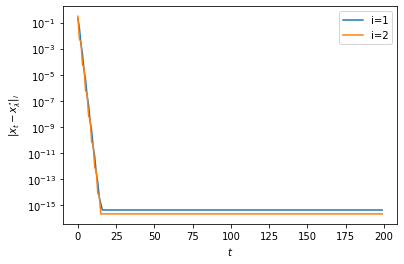

In [33]:
plot_convergence_x(A_2, x_history_2, x_rr_2)

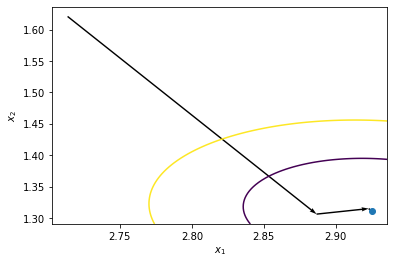

In [35]:
def plot_x_trajectory_2d(f, x_history, x_star, time_avg=False):
    if time_avg:
        x_history = time_average(x_history)
        
    plt.xlabel("$x_{1}$")
    plt.ylabel("$x_{2}$")
    
    plt.plot(x_star[0], x_star[1], 'o')
    
    plt.quiver(x_history[:-1,0], x_history[:-1,1],\
           x_history[1:,0]-x_history[:-1,0], x_history[1:,1]-x_history[:-1,1],\
           scale_units='xy', angles='xy', scale=1)
    
    xmin, xmax, ymin, ymax = plt.axis()
    x_range = np.linspace(start=xmin, stop=xmax, num=100)
    y_range = np.linspace(start=ymin, stop=ymax, num=100)
    xv, yv = np.meshgrid(x_range, y_range)
    z = np.stack((xv, yv), axis=-1)
    fz = np.zeros((z.shape[0], z.shape[1]))
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            fz[i][j] = f(z[i][j])
    min_fz = np.min(fz)
    max_fz = np.max(fz)
    level1 = min_fz + 0.05 * (max_fz - min_fz)
    level2 = min_fz + 0.15 * (max_fz - min_fz)
    plt.contour(x_range, y_range, fz, levels=[level1, level2])
    
plot_x_trajectory_2d(f_2, x_history_2, x_rr_2)